In [1]:
import numpy as np
from run_mzn import run_mzn
from plan_to_dzn import PlanToDZN
from mzn_arr_to_schedule import arr_to_schedule
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
p2d = PlanToDZN(2, False)
p2d.create_from_file('ext_plan.plan')

In [3]:
[m for m in p2d.start_order_constraints if m[0].train.id == 1]

[(Movement(id=1, train=1, direction=Direction.ASIDE, origin=1, destination=2),
  Movement(id=5, train=2, direction=Direction.ASIDE, origin=1, destination=2)),
 (Movement(id=4, train=1, direction=Direction.ASIDE, origin=4, destination=5),
  Movement(id=8, train=2, direction=Direction.ASIDE, origin=4, destination=5))]

In [4]:
p2d.precedence_constraints

[(Movement(id=1, train=1, direction=Direction.ASIDE, origin=1, destination=2),
  Movement(id=2, train=1, direction=Direction.ASIDE, origin=2, destination=3)),
 (Movement(id=2, train=1, direction=Direction.ASIDE, origin=2, destination=3),
  Movement(id=3, train=1, direction=Direction.ASIDE, origin=3, destination=4)),
 (Movement(id=3, train=1, direction=Direction.ASIDE, origin=3, destination=4),
  Movement(id=4, train=1, direction=Direction.ASIDE, origin=4, destination=5)),
 (Movement(id=5, train=2, direction=Direction.ASIDE, origin=1, destination=2),
  Movement(id=6, train=2, direction=Direction.ASIDE, origin=2, destination=3)),
 (Movement(id=6, train=2, direction=Direction.ASIDE, origin=2, destination=3),
  Movement(id=7, train=2, direction=Direction.ASIDE, origin=3, destination=4)),
 (Movement(id=7, train=2, direction=Direction.ASIDE, origin=3, destination=4),
  Movement(id=8, train=2, direction=Direction.ASIDE, origin=4, destination=5)),
 (Movement(id=9, train=3, direction=Direction.

In [5]:
p2d.non_overlap_constraints

[]

In [6]:
[start_times, durations, action_driver, action_train, start_train, end_train] = run_mzn(300, 'chuffed')

{"type": "statistics", "statistics": {"paths": 0, "flatBoolVars": 246, "flatIntVars": 53, "flatBoolConstraints": 114, "flatIntConstraints": 259, "evaluatedReifiedConstraints": 246, "method": "minimize", "flatTime": 0.100948}}
{"type": "statistics", "statistics": {"nSolutions": 65}}


In [12]:
train_schedule = np.ones((np.max(action_train),np.max(start_times)+np.max(durations))) * (len(start_times)+1)
for i in range(len(start_times)):
    train_id = action_train[i]-1
    train_schedule[train_id,start_times[i]:start_times[i]+durations[i]] = i

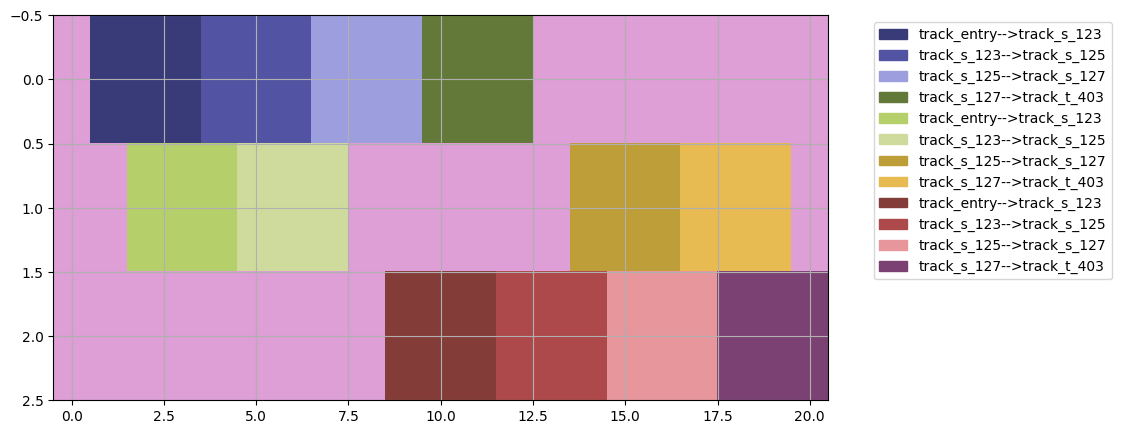

In [13]:
plt.figure(figsize=(10,5))
im = plt.imshow(train_schedule, aspect='auto', cmap='tab20b')
# get the colors of the values, according to the 
# colormap used by imshow
labels = [f'{m.origin.name}-->{m.destination.name}' for m in p2d.movements]
colors = [ im.cmap(im.norm(i)) for i in range(len(labels)+1)]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i] ) for i in range(len(labels)) ]
# put those patched as legend-handles into the legend

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2)

plt.grid(True)